In [136]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import h5py as h5
import numpy as np
import os

from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use("./paper.mplstyle")

from scipy.interpolate import interp1d
from scipy.optimize import ridder

# Set up ASTERIA
import sys
ASTERIA_PATH = "/Users/jlazar/research/ASTERIA"
os.environ["ASTERIA"] = "/Users/jlazar/research/ASTERIA"
sys.path.append(f"{ASTERIA_PATH}/python/")

sys.path.append("../")

from sne_bsm import units, parameterized_flux_from_h5, deserialize

In [3]:
# Where tabulated SM fluxes are stored. See `prepare_h5_file.ipynb` for the expected format
TABULATED_SM_FILE = "data/sm_flux.h5"
# Where to store the parameterized SM flux for later use
SERIALIZED_SM_FILE = "./data/serialized_sm_flux.h5"
# Where tabulated BSM fluxes are stored. See `prepare_h5_file.ipynb` for the expected format
TABULATED_BSM_FILE = "data/majoran_fluxes.h5"
# TABULATED_BSM_FILE = "data/magnetic_moment_fluxes.h5"
# Where to store the parameterized models for later use
SERIALIZED_BSM_FILE = "./data/serialized_majoran_fluxes.h5"
# SERIALIZED_BSM_FILE = "./data/serialized_magnetic_moment_fluxes.h5"
# Where to save the computed sensitivities
RESULTS_FILE = "./data/new_results.h5"
# What to call the results in the ``RESULTS
RESULTS_NAME = "majoron_sensitivities"

# First, we will parameterize the SM flux

In [4]:
if os.path.exists(SERIALIZED_SM_FILE):
    with h5.File(SERIALIZED_SM_FILE, "r") as h5f:
        done_keys = list(h5f.keys())

with h5.File(TABULATED_SM_FILE, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=1, track=False)
        pflux.serialize(SERIALIZED_SM_FILE, key)

100%|██████████| 1/1 [00:00<00:00, 1037.68it/s]


# Next, we will do the same for the BSM fluxes.

Depending on how many fluxes you are considering, this could take awhile...
The `thin` parameter can be increased to make this go faster, but will only use one out of every `thin` time point.

In [5]:
thin = 10

done_keys = []
if os.path.exists(SERIALIZED_BSM_FILE):
    with h5.File(SERIALIZED_BSM_FILE) as h5f:
        done_keys = list(h5f.keys())

with h5.File(TABULATED_BSM_FILE, "r") as h5f:
    for key, group in tqdm(h5f.items()):
        if f"{key}_0" in done_keys:
            continue
        pflux = parameterized_flux_from_h5(group, 10*units.kpc, thin=thin, track=False)
        pflux.serialize(SERIALIZED_BSM_FILE, key)

100%|██████████| 63/63 [00:00<00:00, 4005.84it/s]


# Define the likelihood and such

In [134]:
TMAX = 100 * units["second"]
TMIN = 1e-2 * units["second"]
TMINS = np.logspace(np.log10(TMIN), np.log10(TMAX), 201)
DTS = np.linspace(0.001, 30, 1001) * units["second"]

def find_significance_matrix(
    sig_hits,
    sm_hits,
    bg_hits,
    times,
    tmins=TMINS,
    dts=DTS,
    bg_mismodel=1.0,
    sm_mismodel=1.0
):
    significance = np.full(tmins.shape + dts.shape, np.nan)
    
    n_obs_bits = bg_mismodel * bg_hits + sm_mismodel * sm_hits # the amount you actually see
    n_exp_bits = sig_hits + bg_hits + sm_hits # The amount you expected to see
    
    t_idx_starts = [bisect.bisect_left(times, tmin) for tmin in tmins]
    t_idx_ends = [[bisect.bisect_right(times, tmin + dt) for dt in dts] for tmin in tmins]
    
    for idx, (start, t_idx_end) in enumerate(zip(tmins, t_idx_starts, t_idx_ends)):
        for jdx, end in enumerate(t_idx_end):
            n_obs = np.sum(n_obs_bits[start:end+1])
            n_exp = np.sum(n_exp_bits[start:end+1])
            llh = 2 * (n_exp - n_obs)
            if n_obs > 0:
                llh += 2 * n_obs * np.log(n_obs / n_exp)
            
            significance[idx, jdx] = llh
    
#     for idx, tmin in enumerate(tmins):
#         for jdx, dt in enumerate(dts):
#             m = np.logical_and(tmin < times, times < tmin+dt)
#             if not m.sum():
#                 continue
#             significance[idx, jdx] = likelihood(
#                 sig_hits[m],
#                 sm_hits[m],
#                 bg_hits[m],
#                 bg_mismodel=bg_mismodel,
#                 sm_mismodel=sm_mismodel
                
#             )
    return significance, tmins, dts

def likelihood(
    sig_hits,
    sm_hits,
    bg_hits,
    bg_mismodel=1.0,
    sm_mismodel=1.0
):
    n_obs = (bg_mismodel * bg_hits + sm_mismodel * sm_hits).sum() # the amount you actually see
    n_exp = (sig_hits + bg_hits + sm_hits).sum() # The amount you expected to see
    llh = 2 * (n_exp - n_obs)
    if n_obs > 0:
        llh += 2 * n_obs * np.log(n_obs / n_exp)
    return llh

# Now we can compute the significance

In [126]:
with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)

out = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))
        
        # if mass!=100:
        #     continue
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        out[mass].append((coupling, significance[m].max()))

KeyboardInterrupt: 

# Compute the sensitivity by interpolating in log-space on the points in parameter space from the last step.

In [ ]:
sensitivities = []

for k, v in out.items():
    v = sorted(v)
    
    couplings = np.power(10, [x[0] for x in v])
    significnces = [x[1] for x in v]
    
    try:
        interp = interp1d(np.log(couplings), np.log(significnces))
        f = lambda lc: np.exp(interp(lc)) - 3.841
        res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
        sens = np.exp(res)
        sensitivities.append((k, sens))
    except ValueError:
        pass
    
sensitivities = sorted(sensitivities)

In [ ]:
masses = np.array([x[0] for x in sensitivities])
couplings = np.array([x[1] for x in sensitivities])

if not os.path.exists(RESULTS_FILE):
    with h5.File(RESULTS_FILE, "w") as _:
        pass

with h5.File(RESULTS_FILE, "r+") as h5f:
    if RESULTS_NAME in h5f.keys():
        del h5f[RESULTS_NAME]
    h5f.create_group(RESULTS_NAME)
    h5f[RESULTS_NAME].create_dataset("masses", data=masses)
    h5f[RESULTS_NAME].create_dataset("couplings", data=couplings)

# Now let's do it all again for Gen2

We will estimate this by scaling the number of hits seen in the Gen1 case by the "effective photoncathode area."
We define this to be:
$$
\sum_{i\in\mathrm{modules}} \varepsilon_{i} \times A_{i},
$$
where $\varepsilon_{i}$ and $A_{i}$ are the quantum efficiency (QE) and photocathode area for a given OM.
IceCube has 5,160 optical modules.
4,680 of these use Hamamatsu R7081-02 with a 10-inch photo cathode diameter and a QE of 0.25, while the remaining 480 of these use Hamamatsu R7081-02MOD with a 10-inch photocathode diameter and a QE of 0.34.
See [the IceCube instrumentation on online systems paper](https://arxiv.org/abs/1612.05093) for further details.
IceCube Gen2 will contain 9,600 new optical modules, each with 24 3-inch PMTs with quantum efficiency equal to the high-QE Gen1 OMs.
See [this paper](https://arxiv.org/abs/2008.04323) for details

In [11]:
ep1 = 0.25
ep2 = 0.34

gen1_area = np.pi * (10 / 2)**2
gen2_area = 24 * np.pi * (3 / 2)**2

gen1_eff_pc_area = 4680 * gen1_area * ep1 + 480 * gen1_area * ep2
gen2_eff_pc_area = gen1_eff_pc_area + 9600 * gen2_area * ep2

r = gen2_eff_pc_area / gen1_eff_pc_area

In [12]:
with h5.File(SERIALIZED_SM_FILE, "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)

sm_hits *= r

out = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))

        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bsm_hits *= r
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits *= r
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, bg_hits, bsm_t)
        m = ~np.isnan(significance)
        out[mass].append((coupling, significance[m].max()))

100%|██████████| 63/63 [1:29:24<00:00, 85.15s/it]


In [13]:
sensitivities = []

for k, v in out.items():
    v = sorted(v)
    
    couplings = np.power(10, [x[0] for x in v])
    significnces = [x[1] for x in v]
    
    try:
        interp = interp1d(np.log(couplings), np.log(significnces))
        f = lambda lc: np.exp(interp(lc)) - 3.841
        res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
        sens = np.exp(res)
        sensitivities.append((k, sens))
    except ValueError:
        pass

In [14]:
sensitivities  = sorted(sensitivities)
masses = np.array([x[0] for x in sensitivities])
couplings = np.array([x[1] for x in sensitivities])

if not os.path.exists(RESULTS_FILE):
    with h5.File(RESULTS_FILE, "w") as _:
        pass

with h5.File(RESULTS_FILE, "r+") as h5f:
    if f"{RESULTS_NAME}_gen2" in h5f.keys():
        del h5f[f"{RESULTS_NAME}_gen2"]
    h5f.create_group(f"{RESULTS_NAME}_gen2")
    h5f[f"{RESULTS_NAME}_gen2"].create_dataset("masses", data=masses)
    h5f[f"{RESULTS_NAME}_gen2"].create_dataset("couplings", data=couplings)

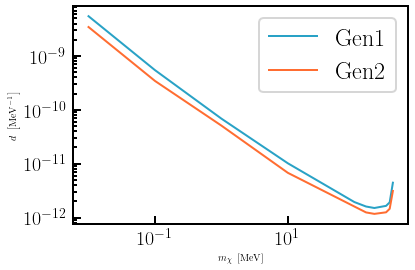

In [15]:
fig, ax = plt.subplots()

for suffix, label in zip(["", "_gen2"], ["Gen1", "Gen2"]):
    with h5.File(RESULTS_FILE) as h5f:
        gp = h5f[f"{RESULTS_NAME}{suffix}"]
        ax.plot(gp["masses"][:], gp["couplings"][:], label=label)

ax.loglog()
ax.legend()
ax.set_xlabel(r"$m_{\chi}~\left[\mathrm{MeV}\right]$")
ax.set_ylabel(r"$d~\left[\mathrm{MeV}^{-1}\right]$")
# Uncomment if doing majoran case
# ax.set_ylabel(r"$g_{\phi}$")
plt.show()

## Let's check out the systematics from modeling uncertainties

In [120]:
SCALINGS = [0.2, 0.8, 0.9, 1.0, 1.1, 1.2, 5]

In [137]:
with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)

bg_hits = flux.get_background(
    shape=sm_hits.shape,
    model_file="magnetic_moment.txt",
    tmax=100 * units["second"]
)

out = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))
        
        if mass not in out:
            out[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
    
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significances = []
        for scaling in SCALINGS:
            significance, _, _ = find_significance_matrix(
                bsm_hits,
                sm_hits,
                bg_hits,
                bsm_t,
                bg_mismodel=1.0,
                sm_mismodel=scaling
            )
            
            m = ~np.isnan(significance)
            significances.append(significance[m].max())
            print(significance[m].max())
        print(significances)
        out[mass].append((coupling, significances))

  0%|          | 0/63 [00:00<?, ?it/s]

8949.60969781698
4821.947193032407
4288.109521217164
3841.0640830394186
3441.8653753719555
3067.7309776417533


  2%|▏         | 1/63 [07:00<7:14:58, 420.94s/it]

80930.44906405848
[8949.60969781698, 4821.947193032407, 4288.109521217164, 3841.0640830394186, 3441.8653753719555, 3067.7309776417533, 80930.44906405848]
4035.8707337946107
298.96332700848143
112.48785139932261
42.52499957320833
46.41436363308094
200.99361195017264


  3%|▎         | 2/63 [13:39<6:54:28, 407.68s/it]

87948.34211497987
[4035.8707337946107, 298.96332700848143, 112.48785139932261, 42.52499957320833, 46.41436363308094, 200.99361195017264, 87948.34211497987]
3822.081644421385
241.12348283702158
61.64290000012625
0.4249467038828243
56.00965949199599
228.4886707132464


  5%|▍         | 3/63 [20:39<6:53:19, 413.32s/it]

88900.14609457343
[3822.081644421385, 241.12348283702158, 61.64290000012625, 0.4249467038828243, 56.00965949199599, 228.4886707132464, 88900.14609457343]
3803.590921995259
236.09014016611764
59.08100253733937
0.004251961076050748
58.34244340041914
233.60588229977293


  6%|▋         | 4/63 [27:44<6:51:00, 417.97s/it]

89035.81726059271
[3803.590921995259, 236.09014016611764, 59.08100253733937, 0.004251961076050748, 58.34244340041914, 233.60588229977293, 89035.81726059271]
3799.005957035639
235.42595883881586
58.7867262481559
4.342721796479765e-05
58.56071165240064
233.96808174404578


  8%|▊         | 5/63 [34:45<6:45:07, 419.09s/it]

89030.06842030957
[3799.005957035639, 235.42595883881586, 58.7867262481559, 4.342721796479765e-05, 58.56071165240064, 233.96808174404578, 89030.06842030957]
3803.9365409441525
236.10602768454555
59.08178406720981
0.0032235386467860394
58.356271809039754
233.64698052714812


 10%|▉         | 6/63 [41:46<6:38:39, 419.65s/it]

89053.58815073641
[3803.9365409441525, 236.10602768454555, 59.08178406720981, 0.0032235386467860394, 58.356271809039754, 233.64698052714812, 89053.58815073641]
3801.6713360950816
235.5646866054667
58.80872960489069
4.2973574809757054e-08
58.63620617766719
234.21931631182088


 11%|█         | 7/63 [48:51<6:33:16, 421.36s/it]

89086.14896169747
[3801.6713360950816, 235.5646866054667, 58.80872960489069, 4.2973574809757054e-08, 58.63620617766719, 234.21931631182088, 89086.14896169747]
3799.069021257339
235.40212820270972
58.76730528903863
5.6100132317382645e-09
58.59859786495872
234.06573579057294


 13%|█▎        | 8/63 [55:27<6:18:53, 413.34s/it]

89017.4345901697
[3799.069021257339, 235.40212820270972, 58.76730528903863, 5.6100132317382645e-09, 58.59859786495872, 234.06573579057294, 89017.4345901697]
3802.6486970655387
235.61389207807224
58.819700102896604
5.085723786546481e-09
58.652268298257695
234.27824447093008


 14%|█▍        | 9/63 [1:02:05<6:07:39, 408.50s/it]

89092.3164182906
[3802.6486970655387, 235.61389207807224, 58.819700102896604, 5.085723786546481e-09, 58.652268298257695, 234.27824447093008, 89092.3164182906]
3803.5951302758767
235.6638813315003
58.83143197489699
5.005531093782434e-09
58.66323508947244
234.31911393579503


 16%|█▌        | 10/63 [1:08:29<5:54:11, 400.97s/it]

89091.25147446478
[3803.5951302758767, 235.6638813315003, 58.83143197489699, 5.005531093782434e-09, 58.66323508947244, 234.31911393579503, 89091.25147446478]
4035.615984386677
298.6905688871557
112.02800442162334
42.128297165120784
46.52912461168307
201.26482872408815


 17%|█▋        | 11/63 [1:14:51<5:42:26, 395.12s/it]

87971.65213831537
[4035.615984386677, 298.6905688871557, 112.02800442162334, 42.128297165120784, 46.52912461168307, 201.26482872408815, 87971.65213831537]
3825.75222842957
241.52690701591928
61.813858880632324
0.43968855350510694
55.95175768896661
228.4475375056645


 19%|█▉        | 12/63 [1:21:13<5:32:28, 391.16s/it]

88956.82008499582
[3825.75222842957, 241.52690701591928, 61.813858880632324, 0.43968855350510694, 55.95175768896661, 228.4475375056645, 88956.82008499582]
45370.96538799658
29316.66990920907
27019.04623837932
24832.147354533314
22742.876965722768
20759.69726092607


 21%|██        | 13/63 [1:27:40<5:25:00, 390.02s/it]

27529.61560317874
[45370.96538799658, 29316.66990920907, 27019.04623837932, 24832.147354533314, 22742.876965722768, 20759.69726092607, 27529.61560317874]
24371.037286254927
12507.414770540723
10948.58533888706
9502.940724205604
8166.756460343284
6941.2991043193615


 22%|██▏       | 14/63 [1:34:10<5:18:31, 390.04s/it]

43231.16199726844
[24371.037286254927, 12507.414770540723, 10948.58533888706, 9502.940724205604, 8166.756460343284, 6941.2991043193615, 43231.16199726844]
13981.187151273887
5234.377682802064
4194.969663677679
3273.9423793878814
2470.62836697686
1789.3637929359538


 24%|██▍       | 15/63 [1:40:36<5:10:59, 388.74s/it]

58236.6954542232
[13981.187151273887, 5234.377682802064, 4194.969663677679, 3273.9423793878814, 2470.62836697686, 1789.3637929359538, 58236.6954542232]
6198.367791256285
1067.5052203085215
630.1257189806493
311.5544627801428
116.89716029073315
27.27567454952259


 25%|██▌       | 16/63 [1:46:59<5:03:15, 387.14s/it]

79055.85325436853
[6198.367791256285, 1067.5052203085215, 630.1257189806493, 311.5544627801428, 116.89716029073315, 27.27567454952259, 79055.85325436853]
4288.946981559857
373.97254597360734
139.98914033803158
24.329816507972282
21.50106648725523
139.79514201128768


 27%|██▋       | 17/63 [1:53:24<4:56:07, 386.25s/it]

86781.80848848657
[4288.946981559857, 373.97254597360734, 139.98914033803158, 24.329816507972282, 21.50106648725523, 139.79514201128768, 86781.80848848657]
3981.8639648634125
284.5747880095587
85.50674745046126
5.388885373031371
39.668453038051666
192.56293421439477


 29%|██▊       | 18/63 [1:59:47<4:49:07, 385.49s/it]

88070.46430635336
[3981.8639648634125, 284.5747880095587, 85.50674745046126, 5.388885373031371, 39.668453038051666, 192.56293421439477, 88070.46430635336]
3883.8829036877432
257.7547330624511
70.44350562711043
1.6736538260865927
48.789559035911225
213.44664637315873


 30%|███       | 19/63 [2:06:12<4:42:31, 385.26s/it]

88568.71409377619
[3883.8829036877432, 257.7547330624511, 70.44350562711043, 1.6736538260865927, 48.789559035911225, 213.44664637315873, 88568.71409377619]
168829.00820733258
151437.11374315945
148655.8813743578
145915.3420413657
143211.8441428339
140540.35685190535


 32%|███▏      | 20/63 [2:12:31<4:34:51, 383.52s/it]

72209.81586811238
[168829.00820733258, 151437.11374315945, 148655.8813743578, 145915.3420413657, 143211.8441428339, 140540.35685190535, 72209.81586811238]
6654.908607686753
1693.7722894492545
1298.265313218908
1005.6730642391121
768.833141170875
600.0753960365182


 33%|███▎      | 21/63 [2:18:52<4:27:49, 382.60s/it]

79136.96523639723
[6654.908607686753, 1693.7722894492545, 1298.265313218908, 1005.6730642391121, 768.833141170875, 600.0753960365182, 79136.96523639723]
4810.477335845149
549.619500400353
266.8900810436244
91.61513989451487
15.792999754234188
80.66618730781192


 35%|███▍      | 22/63 [2:25:12<4:20:52, 381.77s/it]

84721.43131250585
[4810.477335845149, 549.619500400353, 266.8900810436244, 91.61513989451487, 15.792999754234188, 80.66618730781192, 84721.43131250585]
4283.929067776015
370.0912286772873
135.24303273162514
19.74269722435929
17.802221990768885
137.12625507362827


 37%|███▋      | 23/63 [2:31:32<4:14:15, 381.39s/it]

86842.85366317863
[4283.929067776015, 370.0912286772873, 135.24303273162514, 19.74269722435929, 17.802221990768885, 137.12625507362827, 86842.85366317863]
4023.1172332748247
293.5849937321909
89.63512748677022
3.632701058136263
35.19282404073965
183.80538194881228


 38%|███▊      | 24/63 [2:38:01<4:09:16, 383.49s/it]

88021.86031138594
[4023.1172332748247, 293.5849937321909, 89.63512748677022, 3.632701058136263, 35.19282404073965, 183.80538194881228, 88021.86031138594]
3889.2250613951473
256.82715482882486
69.58982978500717
0.4497566710197134
48.89663704147097
214.42591931427887


 40%|███▉      | 25/63 [2:44:25<4:03:03, 383.77s/it]

88759.41374677909
[3889.2250613951473, 256.82715482882486, 69.58982978500717, 0.4497566710197134, 48.89663704147097, 214.42591931427887, 88759.41374677909]
3829.781884725613
241.72578490255546
61.83456215163096
0.042440004965328626
55.827224875778484
228.70808983704046


 41%|████▏     | 26/63 [2:50:51<3:57:00, 384.33s/it]

89035.72946925298
[3829.781884725613, 241.72578490255546, 61.83456215163096, 0.042440004965328626, 55.827224875778484, 228.70808983704046, 89035.72946925298]
104029.75709936989
79916.18867443677
76274.29557140253
72730.71007048397
69278.51476663211
65939.41887759895


 43%|████▎     | 27/63 [2:57:16<3:50:45, 384.59s/it]

14370.92680328677
[104029.75709936989, 79916.18867443677, 76274.29557140253, 72730.71007048397, 69278.51476663211, 65939.41887759895, 14370.92680328677]
25548.002887894283
13147.56694980769
11500.896267645701
9973.981163700926
8562.288039828243
7267.797459125373


 44%|████▍     | 28/63 [3:03:43<3:44:41, 385.20s/it]

40857.82193433656
[25548.002887894283, 13147.56694980769, 11500.896267645701, 9973.981163700926, 8562.288039828243, 7267.797459125373, 40857.82193433656]
8421.400704170694
2099.7020992441976
1463.2248707496328
945.7630492608005
553.407811143552
284.0101422249427


 46%|████▌     | 29/63 [3:10:11<3:38:47, 386.11s/it]

71592.29957690788
[8421.400704170694, 2099.7020992441976, 1463.2248707496328, 945.7630492608005, 553.407811143552, 284.0101422249427, 71592.29957690788]
4702.565180503094
513.8945819075307
235.015390697954
73.41090417485248
16.649821363382216
91.0552739939958


 48%|████▊     | 30/63 [3:16:37<3:32:24, 386.19s/it]

84965.1554140437
[4702.565180503094, 513.8945819075307, 235.015390697954, 73.41090417485248, 16.649821363382216, 91.0552739939958, 84965.1554140437]
3950.503181414824
276.7519182921533
81.18050051674072
5.0389314955427835
41.97988918092233
197.9853002305972


 49%|████▉     | 31/63 [3:23:01<3:25:33, 385.42s/it]

88111.49254438258
[3950.503181414824, 276.7519182921533, 81.18050051674072, 5.0389314955427835, 41.97988918092233, 197.9853002305972, 88111.49254438258]
3826.854936953576
242.13445341499755
62.162926679171505
0.323042646941758
55.44973222052795
227.7025218365161


 51%|█████     | 32/63 [3:29:23<3:18:35, 384.36s/it]

88917.36859437218
[3826.854936953576, 242.13445341499755, 62.162926679171505, 0.323042646941758, 55.44973222052795, 227.7025218365161, 88917.36859437218]
4032.308945525583
296.74339443838835
99.17539034499714
31.225400792864093
44.60530155266679
198.52850716782996


 52%|█████▏    | 33/63 [3:35:42<3:11:27, 382.91s/it]

88120.24942867341
[4032.308945525583, 296.74339443838835, 99.17539034499714, 31.225400792864093, 44.60530155266679, 198.52850716782996, 88120.24942867341]
3878.8590052847285
254.2083177452878
68.35253944485157
2.4106483675602703
51.670277649740456
218.45594239595812


 54%|█████▍    | 34/63 [3:42:00<3:04:20, 381.41s/it]

88854.1865402672
[3878.8590052847285, 254.2083177452878, 68.35253944485157, 2.4106483675602703, 51.670277649740456, 218.45594239595812, 88854.1865402672]
3823.24631244567
241.34845769928506
61.76942197272001
0.1258486908151326
55.76629690131449
228.3137789216853


 56%|█████▌    | 35/63 [3:48:17<2:57:22, 380.08s/it]

88936.1224434094
[3823.24631244567, 241.34845769928506, 61.76942197272001, 0.1258486908151326, 55.76629690131449, 228.3137789216853, 88936.1224434094]
3811.893113389233
237.98144471863634
60.01733951744973
0.010301293001788281
57.47291501238942
231.9091378587691


 57%|█████▋    | 36/63 [3:54:36<2:50:53, 379.77s/it]

89065.53459193371
[3811.893113389233, 237.98144471863634, 60.01733951744973, 0.010301293001788281, 57.47291501238942, 231.9091378587691, 89065.53459193371]
226415.25613244006
206623.75798556925
203454.52326471923
200320.9869221066
197219.52302447672
194149.87469566148


 59%|█████▊    | 37/63 [4:00:53<2:44:12, 378.94s/it]

112877.70899919307
[226415.25613244006, 206623.75798556925, 203454.52326471923, 200320.9869221066, 197219.52302447672, 194149.87469566148, 112877.70899919307]
72826.4467189823
52213.01239485043
49160.147296067036
46210.72791539453
43358.220965697255
40610.89992528816


 60%|██████    | 38/63 [4:07:16<2:38:21, 380.07s/it]

17083.026687766658
[72826.4467189823, 52213.01239485043, 49160.147296067036, 46210.72791539453, 43358.220965697255, 40610.89992528816, 17083.026687766658]
34255.44696135417
19860.9260839966
17874.049555203528
16004.344854557712
14241.349394081568
12590.9313791272


 62%|██████▏   | 39/63 [4:13:41<2:32:35, 381.47s/it]

33323.668817098835
[34255.44696135417, 19860.9260839966, 17874.049555203528, 16004.344854557712, 14241.349394081568, 12590.9313791272, 33323.668817098835]
9926.027084686386
2878.847738399665
2121.692643731134
1482.8146821788978
966.0955904270959
583.0228499726509


 63%|██████▎   | 40/63 [4:20:06<2:26:39, 382.59s/it]

67175.0733771635
[9926.027084686386, 2878.847738399665, 2121.692643731134, 1482.8146821788978, 966.0955904270959, 583.0228499726509, 67175.0733771635]
4977.937882307626
611.8384430859005
304.0990891704714
113.33332831212465
30.953377319507126
69.47763498302993


 65%|██████▌   | 41/63 [4:26:29<2:20:19, 382.70s/it]

83830.6976606655
[4977.937882307626, 611.8384430859005, 304.0990891704714, 113.33332831212465, 30.953377319507126, 69.47763498302993, 83830.6976606655]
4010.37683553886
290.48828826801764
88.84365199011518
7.714697900948522
38.066966515238164
189.27267565661896


 67%|██████▋   | 42/63 [4:32:51<2:13:53, 382.53s/it]

88179.4456713607
[4010.37683553886, 290.48828826801764, 88.84365199011518, 7.714697900948522, 38.066966515238164, 189.27267565661896, 88179.4456713607]
3839.990044542821
244.3446008262399
63.22369020759288
0.49360610457915755
54.630084767839435
226.18267546968855


 68%|██████▊   | 43/63 [4:39:12<2:07:24, 382.24s/it]

88961.66199694248
[3839.990044542821, 244.3446008262399, 63.22369020759288, 0.49360610457915755, 54.630084767839435, 226.18267546968855, 88961.66199694248]
3805.360569921846
236.83177948964294
59.47302041801959
0.02402113550579088
57.92607373289866
232.74239037765074


 70%|██████▉   | 44/63 [4:45:36<2:01:10, 382.65s/it]

89004.70614458527
[3805.360569921846, 236.83177948964294, 59.47302041801959, 0.02402113550579088, 57.92607373289866, 232.74239037765074, 89004.70614458527]
9829764.750402011
9730459.937639775
9714076.612381253
9697740.071583997
9681449.930335205
9665205.810004095


 71%|███████▏  | 45/63 [4:51:54<1:54:22, 381.23s/it]

9103493.59126543
[9829764.750402011, 9730459.937639775, 9714076.612381253, 9697740.071583997, 9681449.930335205, 9665205.810004095, 9103493.59126543]
1885841.5396009893
1833110.297386095
1824466.4881681593
1815863.106682295
1807299.8193407068
1798776.2980157766


 73%|███████▎  | 46/63 [4:58:12<1:47:43, 380.24s/it]

1501565.6896880555
[1885841.5396009893, 1833110.297386095, 1824466.4881681593, 1815863.106682295, 1807299.8193407068, 1798776.2980157766, 1501565.6896880555]
131948.77880787128
106378.98298131826
102420.69489014079
98588.18879853096
94837.01018538093
91166.60654916381


 75%|███████▍  | 47/63 [5:04:30<1:41:14, 379.67s/it]

25693.390396951
[131948.77880787128, 106378.98298131826, 102420.69489014079, 98588.18879853096, 94837.01018538093, 91166.60654916381, 25693.390396951]
6101.028769227909
1036.255408284691
608.9957307459408
299.510779065371
112.55252772502718
26.823570297408878


 76%|███████▌  | 48/63 [5:10:52<1:35:06, 380.45s/it]

79254.48459245078
[6101.028769227909, 1036.255408284691, 608.9957307459408, 299.510779065371, 112.55252772502718, 26.823570297408878, 79254.48459245078]
3831.6522734835744
243.04874075464613
62.591860734559305
0.337886902723767
55.08128672173552
227.0107421118082


 78%|███████▊  | 49/63 [5:17:16<1:28:58, 381.33s/it]

88948.38532916666
[3831.6522734835744, 243.04874075464613, 62.591860734559305, 0.337886902723767, 55.08128672173552, 227.0107421118082, 88948.38532916666]
9088516.89776512
9000857.051124614
8986392.272824237
8971968.054356689
8957584.061831724
8943239.966811473


 79%|███████▉  | 50/63 [5:23:35<1:22:28, 380.65s/it]

8424941.452890445
[9088516.89776512, 9000857.051124614, 8986392.272824237, 8971968.054356689, 8957584.061831724, 8943239.966811473, 8424941.452890445]
1148631.6525198682
1104720.018982947
1097546.6926554516
1090413.9437051765
1083321.4360804087
1076268.8392499727


 81%|████████  | 51/63 [5:29:53<1:15:58, 379.90s/it]

854412.3260868285
[1148631.6525198682, 1104720.018982947, 1097546.6926554516, 1090413.9437051765, 1083321.4360804087, 1076268.8392499727, 854412.3260868285]
66036.0690376652
48074.17602438264
45405.06299119402
42817.93243473198
40312.49713658058
37888.853947182244


 83%|████████▎ | 52/63 [5:36:11<1:09:32, 379.29s/it]

32227.639683444635
[66036.0690376652, 48074.17602438264, 45405.06299119402, 42817.93243473198, 40312.49713658058, 37888.853947182244, 32227.639683444635]
5151.616833214677
657.4831634617294
326.4417199719319
113.36276214491227
18.328147912045097
49.51343986783286


 84%|████████▍ | 53/63 [5:42:34<1:03:24, 380.47s/it]

83150.34130830341
[5151.616833214677, 657.4831634617294, 326.4417199719319, 113.36276214491227, 18.328147912045097, 49.51343986783286, 83150.34130830341]
3821.64769734774
240.13660308805993
61.07557535660817
0.12551550834905356
56.49288692304617
229.9710823018031


 86%|████████▌ | 54/63 [5:48:55<57:05, 380.62s/it]  

89007.70024504024
[3821.64769734774, 240.13660308805993, 61.07557535660817, 0.12551550834905356, 56.49288692304617, 229.9710823018031, 89007.70024504024]
3803.948572109366
235.70396006802184
58.852099862142495
3.3747990030974506e-05
58.63825926126083
234.2646772613516


 87%|████████▋ | 55/63 [5:55:18<50:51, 381.38s/it]

89100.8769238391
[3803.948572109366, 235.70396006802184, 58.852099862142495, 3.3747990030974506e-05, 58.63825926126083, 234.2646772613516, 89100.8769238391]
6758236.558989159
6677552.628992899
6664251.919999825
6650992.157571788
6637773.001447628
6624594.116974708


 89%|████████▉ | 56/63 [6:01:36<44:22, 380.41s/it]

6150801.807719586
[6758236.558989159, 6677552.628992899, 6664251.919999825, 6650992.157571788, 6637773.001447628, 6624594.116974708, 6150801.807719586]
11043730.48845317
10940939.757066341
10923976.377994634
10907060.038033763
10890190.348086704
10873366.925440747


 90%|█████████ | 57/63 [6:07:54<37:57, 379.58s/it]

10265115.592169024
[11043730.48845317, 10940939.757066341, 10923976.377994634, 10907060.038033763, 10890190.348086704, 10873366.925440747, 10265115.592169024]
5127881.393593099
5053804.117125515
5041603.723591438
5029444.060017734
5017324.789718889
5005245.581530085


 92%|█████████▏| 58/63 [6:14:11<31:34, 378.91s/it]

4573113.210956058
[5127881.393593099, 5053804.117125515, 5041603.723591438, 5029444.060017734, 5017324.789718889, 5005245.581530085, 4573113.210956058]
125607.39681513014
110443.41120530304
108033.11283875443
105655.51890108286
103318.88664877543
101017.41548471787


 94%|█████████▎| 59/63 [6:20:27<25:11, 377.99s/it]

65693.06732055894
[125607.39681513014, 110443.41120530304, 108033.11283875443, 105655.51890108286, 103318.88664877543, 101017.41548471787, 65693.06732055894]
3804.0584699558094
236.31024336995324
59.197103326307115
0.004382307818445952
58.22439761352871
233.36765999777708


 95%|█████████▌| 60/63 [6:26:50<18:58, 379.48s/it]

89043.39832047978
[3804.0584699558094, 236.31024336995324, 59.197103326307115, 0.004382307818445952, 58.22439761352871, 233.36765999777708, 89043.39832047978]
3799.7117108182283
235.44573083117575
58.77968614500787
1.1068483871667922e-06
58.60478010861698
234.09638917633856


 97%|█████████▋| 61/63 [6:33:15<12:41, 380.96s/it]

89016.38694841112
[3799.7117108182283, 235.44573083117575, 58.77968614500787, 1.1068483871667922e-06, 58.60478010861698, 234.09638917633856, 89016.38694841112]
4158.6267502474075
337.9022766787748
187.76786657304
95.74737477001145
51.6153917605252
191.6694314135093


 98%|█████████▊| 62/63 [6:39:33<06:20, 380.05s/it]

87353.59202245343
[4158.6267502474075, 337.9022766787748, 187.76786657304, 95.74737477001145, 51.6153917605252, 191.6694314135093, 87353.59202245343]
8240722.150588429
8155342.175056731
8141258.152314684
8127214.901568787
8113212.085441073
8099249.3720912505


100%|██████████| 63/63 [6:45:49<00:00, 386.50s/it]

7595568.610237095
[8240722.150588429, 8155342.175056731, 8141258.152314684, 8127214.901568787, 8113212.085441073, 8099249.3720912505, 7595568.610237095]


In [159]:
out[0.01]

[(-7.5,
  [8949.60969781698,
   4821.947193032407,
   4288.109521217164,
   3841.0640830394186,
   3441.8653753719555,
   3067.7309776417533,
   80930.44906405848]),
 (-8.0,
  [4035.8707337946107,
   298.96332700848143,
   112.48785139932261,
   42.52499957320833,
   46.41436363308094,
   200.99361195017264,
   87948.34211497987]),
 (-8.5,
  [3822.081644421385,
   241.12348283702158,
   61.64290000012625,
   0.4249467038828243,
   56.00965949199599,
   228.4886707132464,
   88900.14609457343]),
 (-9.0,
  [3803.590921995259,
   236.09014016611764,
   59.08100253733937,
   0.004251961076050748,
   58.34244340041914,
   233.60588229977293,
   89035.81726059271]),
 (-9.5,
  [3799.005957035639,
   235.42595883881586,
   58.7867262481559,
   4.342721796479765e-05,
   58.56071165240064,
   233.96808174404578,
   89030.06842030957])]

In [157]:
sensitivities = np.empty((len(SCALINGS), len(out)))

for idx in range(7):

    # idx = 3
    a = []
    
    sorter = np.argsort(list(out.keys()))
    
    for k, v in out.items():
        v = sorted(v)

        couplings = np.power(10, [x[0] for x in v])
        significances = [x[1][idx] for x in v]
        
        try:
            interp = interp1d(np.log(couplings), np.log(significances))
            f = lambda lc: np.exp(interp(lc)) - 3.841
            res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
            sens = np.exp(res)
            a.append(sens) 
            
        except ValueError as e:
            print(f(np.log(couplings[0])))
            print(f(np.log(couplings[-1])))
            pass

    a = np.array(a)
    sensitivities[idx, :] = a[sorter]

3795.164957035641
8945.768697816973
3799.754130275876
4031.774984386677
3880.0419036877456
45367.124387996584
3825.9408847256122
168825.16720733268
3823.0139369535764
104025.9160993699
3808.0521133892316
226411.41513244016
3801.5195699218443
72822.6057189823
3827.811273483577
9829760.909401996
3800.1075721093653
6758232.717989162
3795.870710818226
4154.785750247405


IndexError: index 0 is out of bounds for axis 0 with size 0

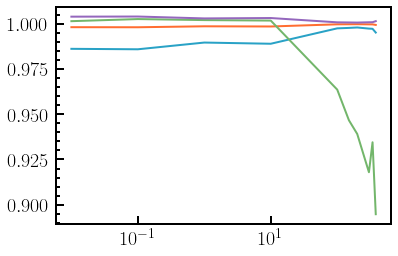

In [149]:
masses = sorted(list(out.keys()))

plt.plot(masses, sensitivities[0, :] / sensitivities[2, :])
plt.plot(masses, sensitivities[1, :] / sensitivities[2, :])
plt.plot(masses, sensitivities[3, :] / sensitivities[2, :])
plt.plot(masses, sensitivities[4, :] / sensitivities[2, :])

plt.semilogx()

plt.show()

In [111]:
with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)

out_ = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))
        
        # if mass!=100:
        #     continue
        if mass not in out_:
            out_[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significances = []
        for scaling in SCALINGS:
            significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, scaling * bg_hits, bsm_t)
                        
            m = ~np.isnan(significance)
            significances.append(significance[m].max())
            
            w = np.where(significance==significance[m].max())
            # print(significance[m].max())
            # print(w)
            # print(TMINS[w[0]] / units.second)
            # print(DTS[w[1]] / units.second)
            # print()
            # print(w)
        out_[mass].append((coupling, significances, TMINS[w[0]], DTS[w[1]]))

/Users/jlazar/miniconda3/envs/ic_sn_hnl/lib/python3.10/site-packages/snewpy/models/base.py:305: RuntimeWarning: divide by zero encountered in log
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
/Users/jlazar/miniconda3/envs/ic_sn_hnl/lib/python3.10/site-packages/snewpy/models/base.py:305: RuntimeWarning: invalid value encountered in subtract
  np.exp(np.log(L) - (2+a)*np.log(Ea) + (1+a)*np.log(1+a)
/Users/jlazar/miniconda3/envs/ic_sn_hnl/lib/python3.10/site-packages/snewpy/models/base.py:306: RuntimeWarning: divide by zero encountered in divide
  - loggamma(1+a) + a*np.log(E) - (1+a)*(E/Ea)) / (u.erg * u.s)
  0%|          | 0/63 [00:00<?, ?it/s]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



  2%|▏         | 1/63 [03:15<3:22:11, 195.67s/it]

[0.01096478]
[0.1134775]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



  3%|▎         | 2/63 [06:29<3:17:37, 194.39s/it]

[0.01096478]
[0.1134775]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]



  5%|▍         | 3/63 [09:12<3:00:01, 180.03s/it]

[0.01096478]
[0.1134775]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]



  6%|▋         | 4/63 [12:04<2:53:56, 176.89s/it]

[0.01       0.01047129]
[0.1134775 0.1134775]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]



  8%|▊         | 5/63 [15:08<2:53:45, 179.74s/it]

[0.01096478]
[0.1134775]

[0.01096478]
[0.1384725]

[0.01096478]
[0.1384725]

[0.01096478]
[0.1384725]

[0.01096478]
[0.1384725]

[0.01096478]
[0.1384725]

[0.01096478]
[0.1384725]



 10%|▉         | 6/63 [17:47<2:44:00, 172.64s/it]

[0.01]
[0.125975]

[0.0144544]
[0.9383125]

[0.01659587]
[0.9633075]

[0.02187762]
[0.95081]

[0.01258925]
[0.95081]

[0.01737801]
[0.9633075]

[0.01659587]
[0.95081]



 11%|█         | 7/63 [20:30<2:38:00, 169.29s/it]

[0.0144544]
[1.0132975]

[0.04168694]
[1.8631275]

[0.02089296]
[1.9631075]

[0.02511886]
[2.025595]

[0.03630781]
[1.9131175]

[0.02630268]
[1.9881025]

[0.03162278]
[2.0006]



 13%|█▎        | 8/63 [23:19<2:35:18, 169.42s/it]

[0.01995262]
[2.2130575]

[0.05011872]
[5.]

[0.03801894]
[4.9625075]

[0.01258925]
[4.9625075]

[0.03630781]
[4.9375125]

[0.03981072]
[4.8625275]

[0.05248075]
[4.975005]



 14%|█▍        | 9/63 [26:11<2:33:06, 170.12s/it]

[0.08317638]
[4.9375125]



 14%|█▍        | 9/63 [26:52<2:41:14, 179.16s/it]


KeyboardInterrupt: 

In [103]:
sensitivities = np.full((7, len(out)), np.nan)

for idx in range(7):

    a = []
    
    sorter = np.argsort(list(out_.keys()))
    
    for k, v in out_.items():
        v = sorted(v)

        couplings = np.power(10, [x[0] for x in v])
        significances = [x[1][idx] for x in v]

        # print(significances)
        
        try:
            interp = interp1d(np.log(couplings), np.log(significances))
            f = lambda lc: np.exp(interp(lc)) - 3.841
            res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
            sens = np.exp(res)
            a.append(sens)
            
            
            
        except ValueError:
            pass
    
    a = np.array(a)
    sensitivities[idx, :] = a[sorter]

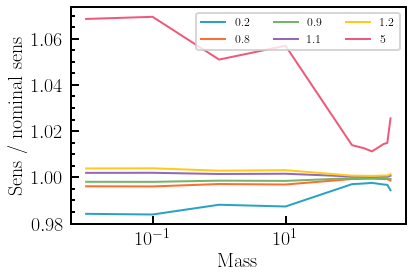

In [115]:
masses = sorted(list(out.keys()))

fig, ax = plt.subplots()

ax.plot(masses, sensitivities[0, :] / sensitivities[3, :], label="0.2")
ax.plot(masses, sensitivities[1, :] / sensitivities[3, :], label="0.8")
ax.plot(masses, sensitivities[2, :] / sensitivities[3, :], label="0.9")
ax.plot(masses, sensitivities[4, :] / sensitivities[3, :], label="1.1")
ax.plot(masses, sensitivities[5, :] / sensitivities[3, :], label="1.2")
ax.plot(masses, sensitivities[6, :] / sensitivities[3, :], label="5")

ax.legend(fontsize=12, ncol=3, loc=1)

ax.set_xlabel("Mass")
ax.set_ylabel("Sens / nominal sens")

ax.semilogx()

plt.show()

In [117]:
with h5.File("data/serialized_sm_flux.h5", "r") as h5f:
    sm_flux = deserialize(h5f["sm_flux_0"])
    
sm_t, sm_hits = sm_flux.get_hits(
    tmax=100 * units["second"],
    model_file="magnetic_moment.txt"
)

out_ = {}

with h5.File(SERIALIZED_BSM_FILE, "r") as h5f:
    for key in tqdm(h5f.keys()):
        key_split = key.split("_")[0].split("-")
        mass = float(key_split[2].replace("MeV", "").replace("d", "."))
        
        # if mass!=100:
        #     continue
        if mass not in out_:
            out_[mass] = []
        coupling = float(f"-{key_split[3][2:].replace('dot', '.')}".replace("d", "."))
        flux = deserialize(h5f[key])
        
        bsm_t, bsm_hits = flux.get_hits(
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        bg_hits = flux.get_background(
            shape=bsm_hits.shape,
            model_file="magnetic_moment.txt",
            tmax=100 * units["second"]
        )
        
        if np.any(sm_t!=bsm_t):
            raise ValueError("Hit times are different !")
            
        significances = []
        for scaling in [0.8, 1.0, 1.2]:
            significance, _, _ = find_significance_matrix(bsm_hits, sm_hits, scaling * bg_hits, bsm_t)
                        
            m = ~np.isnan(significance)
            significances.append(significance[m].max())
            
            w = np.where(significance==significance[m].max())
            # print(significance[m].max())
            # print(w)
            print(TMINS[w[0]] / units.second)
            print(DTS[w[1]] / units.second)
            print()
            # print(w)
        out_[mass].append((coupling, significances, TMINS[w[0]], DTS[w[1]]))

  0%|          | 0/63 [00:00<?, ?it/s]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



  2%|▏         | 1/63 [01:52<1:55:50, 112.11s/it]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]



  3%|▎         | 2/63 [03:41<1:52:09, 110.31s/it]

[0.01]
[0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



  5%|▍         | 3/63 [05:27<1:48:43, 108.72s/it]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



  6%|▋         | 4/63 [07:14<1:46:04, 107.88s/it]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01]
[0.125975]

[0.01]
[0.125975]



  8%|▊         | 5/63 [09:01<1:43:55, 107.50s/it]

[0.01]
[0.125975]

[0.01       0.01047129]
[0.1384725 0.1384725]

[0.01       0.01047129]
[0.1384725 0.1384725]



 10%|▉         | 6/63 [10:48<1:42:00, 107.37s/it]

[0.01       0.01047129]
[0.1384725 0.1384725]

[0.01258925]
[0.975805]

[0.01819701]
[0.925815]



 11%|█         | 7/63 [12:40<1:41:43, 108.99s/it]

[0.02187762]
[0.9633075]

[0.02754229]
[1.9131175]

[0.03467369]
[1.90062]



 13%|█▎        | 8/63 [14:32<1:40:38, 109.79s/it]

[0.02884032]
[2.0380925]

[0.04570882]
[5.]

[0.01513561 0.01584893]
[4.95001 4.95001]



 14%|█▍        | 9/63 [16:23<1:39:16, 110.31s/it]

[0.05754399]
[4.975005]

[0.13803843]
[4.9875025]

[0.12022644]
[4.9875025]



 16%|█▌        | 10/63 [18:15<1:37:43, 110.63s/it]

[0.11481536]
[5.]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



 17%|█▋        | 11/63 [20:01<1:34:38, 109.20s/it]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01047129 0.01096478]
[0.125975 0.125975]



 19%|█▉        | 12/63 [21:47<1:32:09, 108.41s/it]

[0.01047129 0.01096478]
[0.125975 0.125975]

[0.01       0.01047129]
[0.8633275 0.8633275]

[0.01148154]
[0.8383325]



 21%|██        | 13/63 [23:39<1:31:13, 109.47s/it]

[0.01202264 0.01258925]
[0.8383325 0.8383325]

[0.02398833]
[1.0882825]

[0.02398833]
[1.05079]



 22%|██▏       | 14/63 [25:32<1:30:17, 110.56s/it]

[0.02398833]
[1.05079]

[0.02754229]
[1.625675]

[0.02884032]
[1.60068]



 24%|██▍       | 15/63 [27:24<1:28:44, 110.92s/it]

[0.02884032]
[1.60068]

[0.04168694]
[3.125375]

[0.04168694]
[3.125375]



 25%|██▌       | 16/63 [29:16<1:27:04, 111.17s/it]

[0.04168694]
[3.125375]

[0.09549926]
[5.]

[0.08317638]
[5.]



 27%|██▋       | 17/63 [31:05<1:24:51, 110.69s/it]

[0.08317638]
[5.]

[0.15135612]
[5.]

[0.15135612]
[5.]



 29%|██▊       | 18/63 [32:56<1:23:05, 110.79s/it]

[0.15135612]
[5.]

[0.18197009]
[5.]

[0.18197009]
[5.]



 30%|███       | 19/63 [34:48<1:21:23, 110.98s/it]

[0.18197009]
[5.]

[0.01       0.01047129]
[0.1634675 0.1634675]

[0.01047129 0.01096478]
[0.15097 0.15097]



 32%|███▏      | 20/63 [36:34<1:18:37, 109.70s/it]

[0.01047129 0.01096478]
[0.15097 0.15097]

[0.01       0.01047129]
[0.1634675 0.1634675]

[0.01       0.01047129]
[0.1634675 0.1634675]



 33%|███▎      | 21/63 [38:21<1:16:10, 108.82s/it]

[0.01       0.01047129]
[0.1634675 0.1634675]

[0.01       0.01047129]
[0.5133975 0.5133975]

[0.01       0.01047129]
[0.5133975 0.5133975]



 35%|███▍      | 22/63 [40:08<1:14:00, 108.31s/it]

[0.01       0.01047129]
[0.5133975 0.5133975]

[0.01096478]
[0.7883425]

[0.01       0.01047129]
[0.7883425 0.7883425]



 37%|███▋      | 23/63 [41:57<1:12:14, 108.37s/it]

[0.01047129 0.01096478]
[0.75085 0.75085]

[0.01819701]
[1.0132975]

[0.02089296]
[0.975805]



 38%|███▊      | 24/63 [43:49<1:11:09, 109.48s/it]

[0.02089296]
[0.9633075]

[0.03467369]
[1.90062]

[0.03467369]
[1.90062]



 40%|███▉      | 25/63 [45:40<1:09:41, 110.05s/it]

[0.03467369]
[1.90062]

[0.05248075]
[3.65027]

[0.05248075]
[3.65027]



 41%|████▏     | 26/63 [47:32<1:08:14, 110.65s/it]

[0.05248075]
[3.65027]

[0.01096478]
[0.7383525]

[0.01096478]
[0.7133575]



 43%|████▎     | 27/63 [49:24<1:06:39, 111.09s/it]

[0.01148154]
[0.70086]

[0.02630268]
[1.35073]

[0.02754229]
[1.3382325]



 44%|████▍     | 28/63 [51:18<1:05:14, 111.84s/it]

[0.03019952]
[1.3132375]

[0.04570882]
[2.7879425]

[0.04570882]
[2.7879425]



 46%|████▌     | 29/63 [53:10<1:03:23, 111.88s/it]

[0.04365158]
[2.775445]

[0.07585776]
[5.]

[0.07585776]
[5.]



 48%|████▊     | 30/63 [55:03<1:01:44, 112.25s/it]

[0.07585776]
[5.]

[0.16595869]
[5.]

[0.15848932]
[5.]



 49%|████▉     | 31/63 [57:05<1:01:26, 115.21s/it]

[0.15848932]
[5.]



 49%|████▉     | 31/63 [58:20<1:00:12, 112.91s/it]


KeyboardInterrupt: 

In [ ]:
sensitivities = np.full((3, len(out)), np.nan)

for idx in range(3):

    a = []
    
    sorter = np.argsort(list(out_.keys()))
    
    for k, v in out_.items():
        v = sorted(v)

        couplings = np.power(10, [x[0] for x in v])
        significances = [x[1][idx] for x in v]
        
        try:
            interp = interp1d(np.log(couplings), np.log(significances))
            f = lambda lc: np.exp(interp(lc)) - 3.841
            res = ridder(f, np.log(couplings[0]), np.log(couplings[-1]))
            sens = np.exp(res)
            a.append(sens)
            
            
            
        except ValueError:
            pass
    
    a = np.array(a)
    sensitivities[idx, :] = a[sorter]